In [ ]:
!pip install transformers evaluate datasets
!pip install accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 4.3 MB/s eta 0:00:00


In [ ]:
# restart the kernel
# import os
# os._exit(00)

In [ ]:
import requests
import torch
from PIL import Image
from transformers import ViTImageProcessor, ViTForImageClassification
from tqdm import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
# the model name
model_name = "google/vit-base-patch16-224"
# load the image processor
image_processor = ViTImageProcessor.from_pretrained(model_name)
# loading the pre-trained model
model = ViTForImageClassification.from_pretrained(model_name)

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

In [ ]:
from datasets import load_dataset

# download & load the dataset
ds = load_dataset("albertvillanova/medmnist-v2","pathmnist")

Generating train split:   0%|          | 0/89996 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10004 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7180 [00:00<?, ? examples/s]

In [ ]:
labels = ds["train"].features["label"]
labels

ClassLabel(names=['adipose', 'background', 'debris', 'lymphocytes', 'mucus', 'smooth muscle', 'normal colon mucosa', 'cancer-associated stroma', 'colorectal adenocarcinoma epithelium'], id=None)

In [ ]:
import random
import matplotlib.pyplot as plt

def show_image_grid(dataset, split, grid_size=(4,4)):
    # Select random images from the given split
    indices = random.sample(range(len(dataset[split])), grid_size[0]*grid_size[1])
    images = [dataset[split][i]["image"] for i in indices]
    labels = [dataset[split][i]["label"] for i in indices]

    # Display the images in a grid
    fig, axes = plt.subplots(nrows=grid_size[0], ncols=grid_size[1], figsize=(8,8))
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i])
        ax.axis('off')
        ax.set_title(ds["train"].features["label"].int2str(labels[i]))

    plt.show()

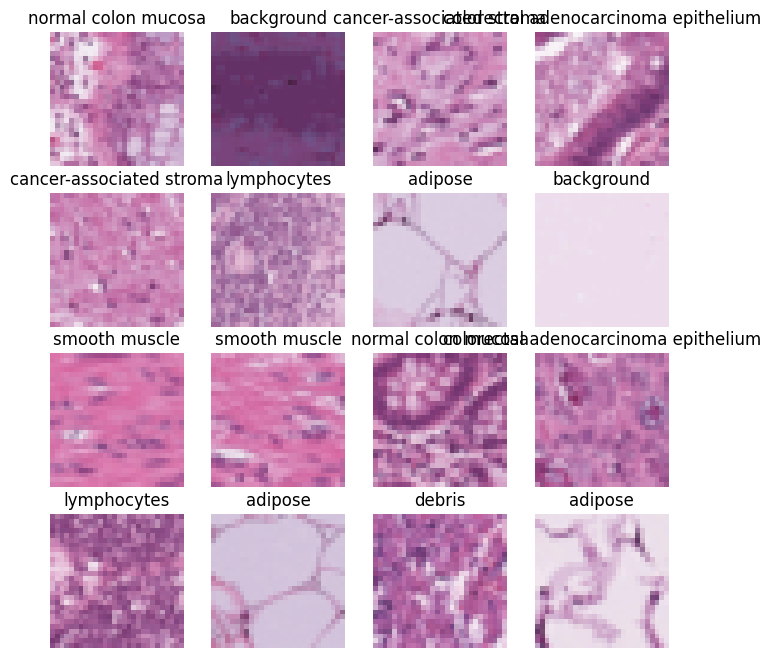

In [ ]:
show_image_grid(ds, "train")

In [ ]:
def transform(examples):
  # convert all images to RGB format, then preprocessing it
  # using our image processor
  inputs = image_processor([img.convert("RGB") for img in examples["image"]], return_tensors="pt")
  # we also shouldn't forget about the labels
  inputs["labels"] = examples["label"]
  return inputs

# use the with_transform() method to apply the transform to the dataset on the fly during training
dataset = ds.with_transform(transform)

In [ ]:
def show_image(dataset, split, index):
    data = dataset[split][index]
    if "image" in data:  # Original dataset
        image = data["image"]
        label = data["label"]

        plt.figure(figsize=(1, 1))
        plt.imshow(image)
        plt.axis('off')
        plt.title(f"Class {label}", fontsize=8)
        plt.show()
    else:  # Transformed dataset
        image_tensor = data['pixel_values']
        label = data['labels']

        # Convert the tensor to a NumPy array and display the
        image_array = image_tensor.numpy()  # Convert the torch tensor to a NumPy array
        plt.figure(figsize=(5, 5))
        plt.imshow(image_array.transpose(1,2,0))  # Matplotlib expects the channel dimension last
        plt.title(f"Class {label}", fontsize=8)
        plt.axis('off')  # Hide the axis
        plt.show()

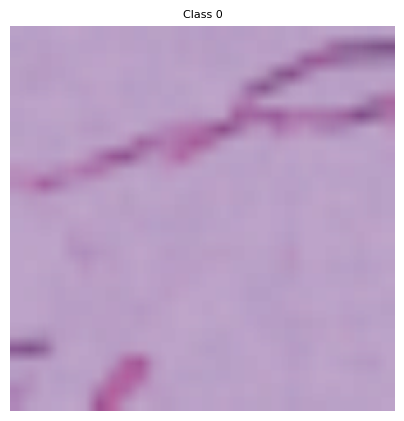

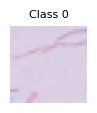

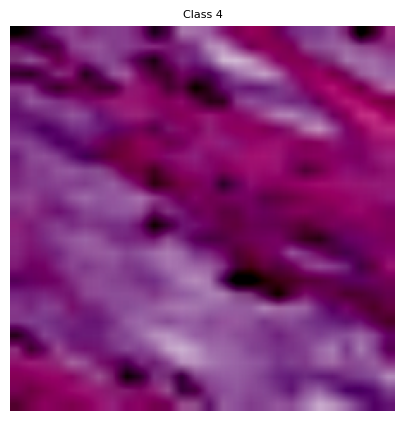

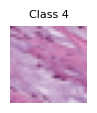

In [ ]:
show_image(dataset, "train",0)
show_image(ds, "train",0)
show_image(dataset, "train",1)
show_image(ds, "train",1)

In [ ]:
for item in dataset["train"]:
  print(item["pixel_values"].shape)
  print(item["labels"])
  break

torch.Size([3, 224, 224])
0


In [ ]:
# extract the labels for our dataset
labels = ds["train"].features["label"].names
labels

['adipose',
 'background',
 'debris',
 'lymphocytes',
 'mucus',
 'smooth muscle',
 'normal colon mucosa',
 'cancer-associated stroma',
 'colorectal adenocarcinoma epithelium']

In [ ]:
def collate_fn(batch):
  return {
      "pixel_values": torch.stack([x["pixel_values"] for x in batch]),
      "labels": torch.tensor([x["labels"] for x in batch]),
  }

In [ ]:
from evaluate import load
import numpy as np

# load the accuracy and f1 metrics from the evaluate module
accuracy = load("accuracy")
f1 = load("f1")

def compute_metrics(eval_pred):
  # compute the accuracy and f1 scores & return them
  accuracy_score = accuracy.compute(predictions=np.argmax(eval_pred.predictions, axis=1), references=eval_pred.label_ids)
  f1_score = f1.compute(predictions=np.argmax(eval_pred.predictions, axis=1), references=eval_pred.label_ids, average="macro")
  return {**accuracy_score, **f1_score}

In [ ]:
# load the ViT model
model = ViTForImageClassification.from_pretrained(
    model_name,
    num_labels=len(labels),
    id2label={str(i): c for i, c in enumerate(labels)},
    label2id={c: str(i) for i, c in enumerate(labels)},
    ignore_mismatched_sizes=True,
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([9]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([9, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments(
  output_dir="./vit-base-food", # output directory
  # output_dir="./vit-base-skin-cancer",
  per_device_train_batch_size=32, # batch size per device during training
  evaluation_strategy="steps",    # evaluation strategy to adopt during training
  num_train_epochs=2,             # total number of training epochs
  # fp16=True,                    # use mixed precision
  save_steps=1000,                # number of update steps before saving checkpoint
  eval_steps=1000,                # number of update steps before evaluating
  logging_steps=1000,             # number of update steps before logging
  # save_steps=50,
  # eval_steps=50,
  # logging_steps=50,
  save_total_limit=2,             # limit the total amount of checkpoints on disk
  remove_unused_columns=False,    # remove unused columns from the dataset
  push_to_hub=False,              # do not push the model to the hub
  report_to='tensorboard',        # report metrics to tensorboard
  load_best_model_at_end=True,    # load the best model at the end of training
)


In [ ]:
from transformers import Trainer

trainer = Trainer(
    model=model,                        # the instantiated 🤗 Transformers model to be trained
    args=training_args,                 # training arguments, defined above
    data_collator=collate_fn,           # the data collator that will be used for batching
    compute_metrics=compute_metrics,    # the metrics function that will be used for evaluation
    train_dataset=dataset["train"],     # training dataset
    eval_dataset=dataset["validation"], # evaluation dataset
    tokenizer=image_processor,          # the processor that will be used for preprocessing the images
)

In [ ]:
# start training
trainer.train()

Step,Training Loss,Validation Loss,Accuracy,F1
1000,0.194200,0.076008,0.976010,0.976083
2000,0.085500,0.061995,0.981507,0.981606
3000,0.052300,0.037508,0.989504,0.989541
4000,0.020700,0.026093,0.992203,0.992105
5000,0.015700,0.018965,0.994002,0.993935


TrainOutput(global_step=5626, training_loss=0.06681901739875151, metrics={'train_runtime': 7667.6508, 'train_samples_per_second': 23.474, 'train_steps_per_second': 0.734, 'total_flos': 1.3948813271417537e+19, 'train_loss': 0.06681901739875151, 'epoch': 2.0})

In [ ]:
trainer.evaluate(dataset["test"])

{'eval_loss': 0.24579666554927826,
 'eval_accuracy': 0.9448467966573816,
 'eval_f1': 0.92659778591983,
 'eval_runtime': 113.449,
 'eval_samples_per_second': 63.288,
 'eval_steps_per_second': 7.915,
 'epoch': 2.0}

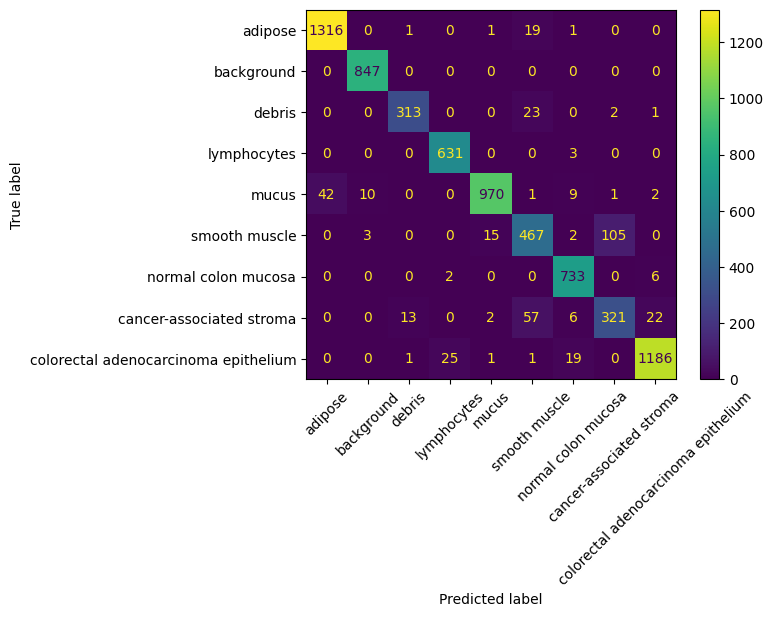

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

outputs = trainer.predict(dataset["test"])
y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(1)

labels = dataset["train"].features['label'].names
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(xticks_rotation=45)

In [ ]:
from sklearn.metrics import precision_recall_fscore_support

precision, recall, f1_score, support = precision_recall_fscore_support(y_true, y_pred, average=None)
precision, recall, f1_score, support

(array([0.96907216, 0.98488372, 0.95426829, 0.95896657, 0.98078868,
        0.8221831 , 0.94825356, 0.74825175, 0.97452753]),
 array([0.98355755, 1.        , 0.92330383, 0.99526814, 0.93719807,
        0.78885135, 0.98920378, 0.76247031, 0.96188159]),
 array([0.97626113, 0.9923843 , 0.93853073, 0.97678019, 0.95849802,
        0.80517241, 0.9682959 , 0.75529412, 0.96816327]),
 array([1338,  847,  339,  634, 1035,  592,  741,  421, 1233]))